The code in this Jupyter notebook produces the figures in "Drivers of Physical and Economic Impacts of Water Scarcity in Latin America and the Caribbean."

Please contact abigail.birnbaum@tufts.edu with any questions.

See https://github.com/flannerydolan/GCAM.surplus/blob/master/R/process_query.R for an explanation by Flannery Dolan of how the scenarios are referenced in the dataframes.

Socioeconomics (SOC) and agriculture (AG) dimensions correspond to the respective SSPs (1-5)

If other SSP factors (OSF) are linked to SOC then OSF = 1. If linked to AG, OSF = 2

Groundwater Availability (GW): Low groundwater (5%) = 1, medium (25%) = 2, high  (40%) = 3

Reservoir Storage (RES): restricted = 1, expanded = 2

Earth System Models (ESM): gfdl = 1, hadgem = 2, ipsl = 3, miroc = 4, noresm = 5

Land use tax policy (TAX): ffict = 1, uct = 2

# Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore') #for not printing warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load in Data

In [7]:
#Path to where data is kept. Change this to reflect the appropriate location on your machine
fpath = 'C:/Users/abirnb01/Documents/Research/NEXO-UA/Paper1/LACwaterscarcity/data/'
#fpath = 'C:/Users/birnb/Documents/Tufts Research/NEXO-UA/LACwaterscarcity/data/'

#load pickle that contains values for scarcity metrics
metrics = pd.read_pickle(fpath+'query_results/scarcity_metrics')

#load in pickle that has basins in LAC
lac_basins = pd.read_pickle(fpath+'map_shapefiles/LAC_basins/lac_basins')

#load in regression results (variable importance scores)
regr_pws = pd.read_csv(fpath+'CART_results/regr_pws.csv')
regr_wprice = pd.read_csv(fpath+'CART_results/regr_wprice.csv')
regr_cropprofit = pd.read_csv(fpath+'CART_results/regr_cropprofit.csv')
df_regr = pd.concat([regr_wprice,regr_cropprofit,regr_pws])
df_regr = df_regr.drop(['Unnamed: 0'],axis=1)

#global weighted average water price for each scenario
#for each scenario, calculate the average global water price
glob_wprice = pd.read_pickle(fpath+'query_results/glob_wprice') #units are already $2020/m3

#looking at land allocation for two scenarios with ffict vs uct in the rio grande
riogrande_tax_lalloc = pd.read_pickle(fpath+'query_results/riogrande_tax_lalloc')

#convert any dollar amounts from $1975 to $2020
#use World Bank deflator: https://data.worldbank.org/indicator/NY.GDP.DEFL.ZS?locations=US&view=chart
#in 1975, 28.511 and in 2020, 108.556
#so multiply prices by 3.81 (108.556/28.511) to get values in $2020
cf = 3.81
metrics['price_scenario'] = metrics['price_scenario']*cf #units are now $2020/m3
metrics['price_unlimited'] = metrics['price_unlimited']*cf #units are now $2020/m3
metrics['profit_scenario'] = metrics['profit_scenario']*cf #units are now $2020
metrics['profit_unlimited'] = metrics['profit_unlimited']*cf #units are now $2020


In [8]:
#merge the scarcity metrics dataframe with the global water price dataframe
metrics_glob = metrics.merge(glob_wprice,on=['year','res','esm','tax','soc','ag','osf','gw'])

esm_dict = {1:'gfdl',2:'hadgem2',3:'ipsl',4:'miroc',5:'noresm'}
ag_dict = {1:'ssp1',2:'ssp2',3:'ssp3',4:'ssp4',5:'ssp5'}
soc_dict = {1:'ssp1',2:'ssp2',3:'ssp3',4:'ssp4',5:'ssp5'}
res_dict = {1:'restricted',2:'expanded'}
gw_dict = {1:'low',2:'med',3:'high'}
tax_dict = {1:'ffict',2:'uct'}
osf_dict = {1:'from_soc',2:'from_ag'}

#rename all of the parameter assumptions with their longform name
metrics_glob['esm'] = metrics_glob['esm'].map(esm_dict)
metrics_glob['ag'] = metrics_glob['ag'].map(ag_dict)
metrics_glob['soc'] = metrics_glob['soc'].map(soc_dict)
metrics_glob['tax'] = metrics_glob['tax'].map(tax_dict)
metrics_glob['res'] = metrics_glob['res'].map(res_dict)
metrics_glob['gw'] = metrics_glob['gw'].map(gw_dict)
metrics_glob['osf'] = metrics_glob['osf'].map(osf_dict)

#save as CSV
#metrics_glob.to_csv(fpath+'query_results/scarcity_metrics.csv')

# Figure 1: Map of Median and Worst First Percentile for Scarcity Metrics

Figure 1 is a map of median (in 2015 and 2100) and worst first percentile (in 2100) point values across scenarios for the 40 LAC basins for the three scarcity metrics.

In [4]:
def map_stat(df,yr,metric,n_val):
    """This function calculates the desired quantile for an input dataframe, year, and metric
    Input:
    df = input dataframe of metrics
    yr = year to calculate statistic for
    metric = metric to calculate statistic for
    n_val = desired quantile (between 0 and 1)
    
    Output:
    dataframe with statistic calculated for the specified yr, metric, n_val
    """
    
    #filter dataframe to year of interest
    df_filt = df[df.year==yr]
    
    #drop duplicate values from dataframe (for scenarios that have same soc, ag but different ssp - these are the same)
    df_filt = df_filt.drop_duplicates(subset=['basin','year','gw','res','tax','soc','ag','esm','pws'],keep='first')
        
    #calculate n_val quantile for metric of interest for all basins
    df_stat = df_filt.groupby(['basin'])[metric].quantile(n_val)
    df_stat = pd.DataFrame(df_stat) #convert result from series to dataframe
    
    #get just the basin name and geometry (for mapping) from df_filt
    df_basins = df_filt.filter(['basin','geometry'])
    df_basins = df_basins.drop_duplicates() #drop all the extra rows (so each basin only appears once)
    
    #merge df_basins with df_stat (so mapping is included in stats dataframe)
    df_stat = df_basins.merge(df_stat,on=['basin'])
    
    return df_stat #return df_stat

#merge the metrics dataframe with the lac_basins dataframe
metrics_map = lac_basins.merge(metrics,on=['basin'])

#CALCULATE STATISTICS - MEDIAN for 2015, 2100 for each metric and WORST FIRST PERCENTILE for 2100 for each metric
med_wprice_2015 = map_stat(metrics_map,2015,'price_scenario',0.5) #water price 2015 median
med_profit_2015 = map_stat(metrics_map,2015,'profit_pchange',0.5) #crop profit 2015 median
med_pws_2015 = map_stat(metrics_map,2015,'pws',0.5) #physical water scarcity 2015 median
med_wprice_2100 = map_stat(metrics_map,2100,'price_scenario',0.5) #water price 2100 median
med_profit_2100 = map_stat(metrics_map,2100,'profit_pchange',0.5) #crop profit 2100 median
med_pws_2100 = map_stat(metrics_map,2100,'pws',0.5) #physical water scarcity 2100 median
wfp_wprice_2100 = map_stat(metrics_map,2100,'price_scenario',1-0.01) #water price 2100 worst first percentile
wfp_profit_2100 = map_stat(metrics_map,2100,'profit_pchange',0.01) #crop profit 2100 worst first percentile
wfp_pws_2100 = map_stat(metrics_map,2100,'pws',1-0.01) #physical water scarcity 2100 worst first percentile

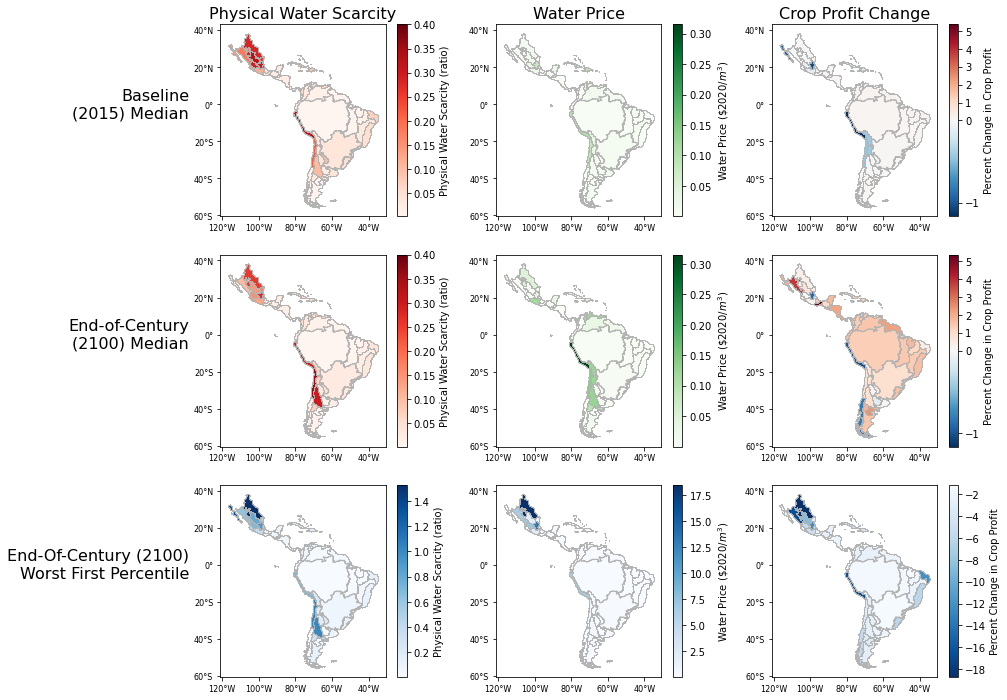

In [5]:
#PLOT STATISTICS ON MAP
#create map
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(nrows=3, ncols=3,figsize=(14,12))   

#set min and max of colorbars for the first two rows (median) of plot
min14 = min(min(med_pws_2015['pws']),min(med_pws_2100['pws'])) #min of 2015, 2100 physical water scarcity median
max14 = max(max(med_pws_2015['pws']),max(med_pws_2100['pws'])) #max of 2015, 2100 physical water scarcity median
min25 = min(min(med_wprice_2015['price_scenario']),min(med_wprice_2100['price_scenario'])) #min of 2015, 2100 water price median
max25 = max(max(med_wprice_2015['price_scenario']),max(med_wprice_2100['price_scenario'])) #max of 2015, 2100 water price median
min36 = min(min(med_profit_2015['profit_pchange']),min(med_profit_2100['profit_pchange'])) #min of 2015, 2100 crop profit median
max36 = max(max(med_profit_2015['profit_pchange']),max(med_profit_2100['profit_pchange'])) #max of 2015, 2100 crop profit median
max14 = 0.4 #threshold for physical water scarcity

#plot physical water scarcity 2015 median
fig1 = med_pws_2015.plot(ax=ax1,column='pws',legend=True,cmap='Reds',edgecolor='#b3b3b3',vmin=min14,vmax=max14,
          legend_kwds={'label':'Physical Water Scarcity (ratio)','orientation':'vertical'})
#plot water price 2015 median
med_wprice_2015.plot(ax=ax2,column='price_scenario',legend=True,cmap='Greens',edgecolor='#b3b3b3',
              legend_kwds={'label':r'Water Price (\$2020/$m^3$)','orientation':'vertical'},vmin=min25,vmax=max25,)
#plot crop profit 2015 median
cbarnorm = mcolors.TwoSlopeNorm(vmin=min36, vcenter=0, vmax = max36) #set divergining colorbar with zero at center
med_profit_2015.plot(ax=ax3,column='profit_pchange',legend=True,cmap='RdBu_r',edgecolor='#b3b3b3',
              norm=cbarnorm,vmin=min36,vmax=max36,
                     legend_kwds={'label':'Percent Change in Crop Profit','orientation':'vertical'})

#plot physical water scarcity 2100 median
med_pws_2100.plot(ax=ax4,column='pws',legend=True,cmap='Reds',edgecolor='#b3b3b3',vmin=min14,vmax=max14,
      legend_kwds={'label':'Physical Water Scarcity (ratio)','orientation':'vertical'})
#plot water price 2100 median
med_wprice_2100.plot(ax=ax5,column='price_scenario',legend=True,cmap='Greens',edgecolor='#b3b3b3',vmin=min25,vmax=max25,
                           legend_kwds={'label':r'Water Price (\$2020/$m^3$)','orientation':'vertical'})
#plot crop profit 2100 median
med_profit_2100.plot(ax=ax6,column='profit_pchange',legend=True,cmap='RdBu_r',edgecolor='#b3b3b3',
                     norm=cbarnorm, legend_kwds={'label': 'Percent Change in Crop Profit','orientation':'vertical'})

#plot physical water scarcity 2100 worst first percentile
wfp_pws_2100.plot(ax=ax7,column='pws',legend=True,cmap='Blues',edgecolor='#b3b3b3',
legend_kwds={'label': 'Physical Water Scarcity (ratio)','orientation':'vertical'})
#plot water price 2100 worst first percentile
wfp_wprice_2100.plot(ax=ax8,column='price_scenario',legend=True,cmap='Blues',edgecolor='#b3b3b3',
      legend_kwds={'label':r'Water Price (\$2020/$m^3$)','orientation':'vertical'})
#plot crop profit 2100 worst first percentile
wfp_profit_2100.plot(ax=ax9,column='profit_pchange',legend=True,cmap='Blues_r',edgecolor='#b3b3b3',
  legend_kwds={'label': 'Percent Change in Crop Profit','orientation':'vertical'})

#making latitude/longitude text labels smaller
axlbl = fig.axes[1]
ticksizes = axlbl.figure
for i in range(9):
    cb_ax = ticksizes.axes[i]
    cb_ax.tick_params(labelsize=8)
     #label maps with lat/lon coordinates
    cb_ax.set_xticklabels(['140°W','120°W','100°W','80°W','60°W','40°W','20°W'])
    cb_ax.set_yticklabels(['80°S','60°S','40°S','20°S','0°','20°N','40°N','60°N'])
    cb_ax = ticksizes.axes[i+9]
    cb_ax.tick_params(labelsize=10)

#set titles for rows/columns
ax1.set_ylabel('Baseline\n(2015) Median',size=16,rotation=0,ha='right')
ax4.set_ylabel('End-of-Century\n(2100) Median',size=16,rotation=0,ha='right')
ax7.set_ylabel('End-Of-Century (2100)\nWorst First Percentile',size=16,rotation=0,ha='right')
ax1.set_title('Physical Water Scarcity',size=16)
ax2.set_title('Water Price',size=16)
ax3.set_title('Crop Profit Change',size=16)

#print plot
plt.show()

# Figure 2: Random Forest Heatmaps for Scarcity Metrics

Figure 2 is a set of three heatmaps showing the normalized parameter importance scores for each of the scarcity metrics across all LAC basins using bagged regression trees

See R scripts at /scripts/main_figures/CART_regression_physicalwaterscarcity.R, /scripts/main_figures/CART_regression_waterprice.R, and
/scripts/main_figures/CART_regression_cropprofit.R for the code used to generate the regression trees and parameter importance scores

In [6]:
def regr_heatmap(df,metric,clmap):
    """This function plots the normalized variable importance scores from the random forest regression 
    as a heatmap
    Input:
    df = input dataframe with variable importance scores
    metric = metric to plot on heatmap
    clmap = what colormap to use for plotting
    
    Output:
    df_table = normalized feature importance scores for each metric
    """
    
    #clean up input dataframe to have just the data we need (drop year = 2100, metric, %IncMSE)
    df_table = df.drop(columns=['%IncMSE','metric','year'])
    
    df_table['basin'] = df_table['basin'].replace({'Rio Grande River':'Rio Grande'})
    
    #Normalize the variable importances across basins
    for bs in df_table.basin.unique()[:]: #loop through the basins
        df_filt = df_table[df_table.basin==bs] #select basin 
        sum_val = df_filt['IncNodePurity'].sum() #sum up the raw IncNodePurity variable importance values
        df_table.loc[df_table['basin']==bs,'norm_IncNodePurity'] = df_table['IncNodePurity']/sum_val #normalize
    
    #pivot the dataframe for heatmap plotting
    df_pivot = pd.pivot_table(data=df_table,values='norm_IncNodePurity',index=['basin'],columns=['varnames'])
    
    
    df_pivot = df_pivot.filter(['ag','soc','osf','esm','gw','res','tax']) #reorder columns (x-axis) of heatmap
    
    #reorder rows to be generally geographical North to South
#     df_pivot = df_pivot.reindex(['Baja California','Mexico-Northwest Coast',
#                                  'Rio Grande River','Mexico-Interior','North Gulf',
#                                  'Rio Lerma','Rio Verde',
#                                  'Pacific Central Coast','Rio Balsas','Papaloapan',
#                                  'Isthmus of Tehuantepec','Grijalva-Usumacinta',
#                                  'Yucatan Peninsula','Southern Central America',
#                                  'Caribbean','Magdalena','Caribbean Coast','Orinoco',
#                                  'Northeast South America-South Atlantic Coast',
#                                  'Amazon','Tocantins','North Brazil-South Atlantic Coast',
#                                  'Parnaiba','East Brazil-South Atlantic Coast','Sao Francisco',
#                                  'Uruguay-Brazil-South Atlantic Coast','Colombia-Ecuador-Pacific Coast',
#                                  'Peru-Pacific Coast','North Chile-Pacific Coast','South Chile-Pacific Coast',
#                                  'La Puna Region','La Plata','Salinas Grandes','Mar Chiquita',
#                                  'South America-Colorado','Pampas Region','North Argentina-South Atlantic Coast',
#                                  'Negro','Central Patagonia Highlands','South Argentina-South Atlantic Coast'
#                                 ])
    #PLOT
#     plt.figure(figsize=(3,15))
#     sns.heatmap(df_pivot,cmap=clmap, 
#                 cbar_kws={'label':metric,'orientation':'horizontal'},
#                 xticklabels=['AG','SOC','OSF','ESM','GW','RES','TAX'], yticklabels=False,
#                annot=True,fmt='.2f')
#     plt.title(metric)
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.show()

    return df_table #return table of dataframe values

In [7]:
#combine the three regression dataframes
regr_pws_norm = regr_heatmap(df_regr[df_regr.metric=='pws'],'Physical Water Scarcity','Reds')
regr_wprice_norm = regr_heatmap(df_regr[df_regr.metric=='water_price'],'Water Price','Greens')
regr_profit_norm = regr_heatmap(df_regr[df_regr.metric=='crop_profit'],'Crop Profit Change','Blues')

In [8]:
#sum up across all the basins for PWS
pws_sum = regr_pws_norm.groupby(['varnames'])['norm_IncNodePurity'].sum()
pws_sum = pws_sum.reset_index()
pws_sum['pct_total'] = 100*pws_sum['norm_IncNodePurity']/40
display(pws_sum.sort_values('norm_IncNodePurity',ascending=False))

#sum up across all the basins for water price
wp_sum = regr_wprice_norm.groupby(['varnames'])['norm_IncNodePurity'].sum()
wp_sum = wp_sum.reset_index()
wp_sum['pct_total'] = 100*wp_sum['norm_IncNodePurity']/40
display(wp_sum.sort_values('norm_IncNodePurity',ascending=False))

#sum up across all the basins for change in crop profit
cp_sum = regr_profit_norm.groupby(['varnames'])['norm_IncNodePurity'].sum()
cp_sum = cp_sum.reset_index()
cp_sum['pct_total'] = 100*cp_sum['norm_IncNodePurity']/40
display(cp_sum.sort_values('norm_IncNodePurity',ascending=False))

,varnames,norm_IncNodePurity,pct_total
4,res,20.618739,51.546848
5,soc,7.318816,18.297040
0,ag,4.753679,11.884198
1,esm,3.311627,8.279068
3,osf,2.421550,6.053875
6,tax,1.533940,3.834851
2,gw,0.041648,0.104121


,varnames,norm_IncNodePurity,pct_total
4,res,12.480228,31.200570
5,soc,8.202333,20.505833
0,ag,5.791355,14.478389
3,osf,4.733480,11.833701
1,esm,4.621192,11.552981
6,tax,3.006496,7.516239
2,gw,1.164915,2.912288


,varnames,norm_IncNodePurity,pct_total
1,esm,9.830083,24.575208
0,ag,8.745224,21.863059
5,soc,7.039059,17.597648
6,tax,4.235927,10.589817
3,osf,3.915485,9.788712
4,res,3.566049,8.915123
2,gw,2.668173,6.670433


# Figure 3: Scatterplots of Severity versus Uncertainity for Scarcity Metrics

This figure plots severity (y-axis) versus uncertainity (x-axis) for all of the basins in 2100 for each of the three scarcity metrics. Each point on a scatterplot represents a basin

In [9]:
def get_sev_unc(df,glob_wprice):
    """This function calculates severity and uncertainity values for each basin/metric/year combo
    
    Inputs:
    df = input dataframe that contains metric values for each scenario
    glob_wprice = global weighted average water price for each scenario
    
    Outputs:
    res_data = dataframe that contains uncertainty/severity values for each basin/year/metric combo
    """
    #merge metrics with global weighted average water price
    df = df.merge(glob_wprice,on=['year','gw','res','esm','tax','soc','ag','osf'])
    df['greateravg'] = df['price_scenario'] >= 1.1*df['weighted_price_scenario'] #is our water price>global average?
        
    basins = df.basin.unique()[:] #list of basins to loop through
    years = [2050,2075,2100] #list of years to loop through - here we're just looking at 2100

    stats_stor = [] #create empty storage list
    
    for bas in basins: #loop through basins
        for yr in years: #loop through years
            df_filt = df[(df.year==yr) & (df.basin==bas)] #limit df to single basin/year combo to calculate severity/uncertainty
            
            #drop duplicates (ag, soc the same SSP so OSF parameter doesn't matter)
            df_filt = df_filt.drop_duplicates(subset=['basin','year','gw','res','tax','soc','ag','esm','pws'],keep='first')
            
            #SEVERITY
            #for water price - severe is % of scenarios with price higher than global mean price for that scenario
            sev_wprice = 100*(np.sum(df_filt['greateravg'])/len(df_filt))
            #for profit - severe is % of scenarios with % profit change <-5%
            sev_profit = 100*(len(df_filt[df_filt['profit_pchange']<=-5])/len(df_filt))
            #for pws - severe is % of scenarios with pws > 0.4
            sev_pws = 100*(len(df_filt[df_filt['pws']>0.4])/len(df_filt))

            #UNCERTAINTY - IQR for each metric (75th percentile - 25th percentile)
            unc_wprice = df_filt['price_scenario'].quantile(0.75) - df_filt['price_scenario'].quantile(0.25)
            unc_profit = df_filt['profit_pchange'].quantile(0.75) - df_filt['profit_pchange'].quantile(0.25)
            unc_pws = df_filt['pws'].quantile(0.75) - df_filt['pws'].quantile(0.25)

            data_stor = [] #create empty list for storing severity/uncertainity values for each basin
            data_stor.append(bas) #append basin name
            data_stor.append(yr) #append year
            data_stor.append(sev_wprice) #append water price severity
            data_stor.append(sev_profit) #append crop profit severity
            data_stor.append(sev_pws) #append physical water scarcity severity  
            data_stor.append(unc_wprice) #append water price uncertainty
            data_stor.append(unc_profit) #append crop profit uncertainty
            data_stor.append(unc_pws) #append physical water scarcity uncertainty
    
            stats_stor.append(data_stor) #append data_stor for basin to list that contains all basin results

    res_data = pd.DataFrame(stats_stor) #make stats_stor into dataframe called res_data
    res_data = res_data.rename(columns={0:'basin',1:'year',2:'sev_wprice',3:'sev_profit',4:'sev_pws',
                                        5:'unc_wprice',6:'unc_profit',7:'unc_pws'}) #rename columns of res_data
    return res_data


In [10]:
df_stats = get_sev_unc(metrics,glob_wprice) #get severity and uncertainty
yr = 2100
stats_yr = df_stats[df_stats.year==yr] #specify that the year is 2100

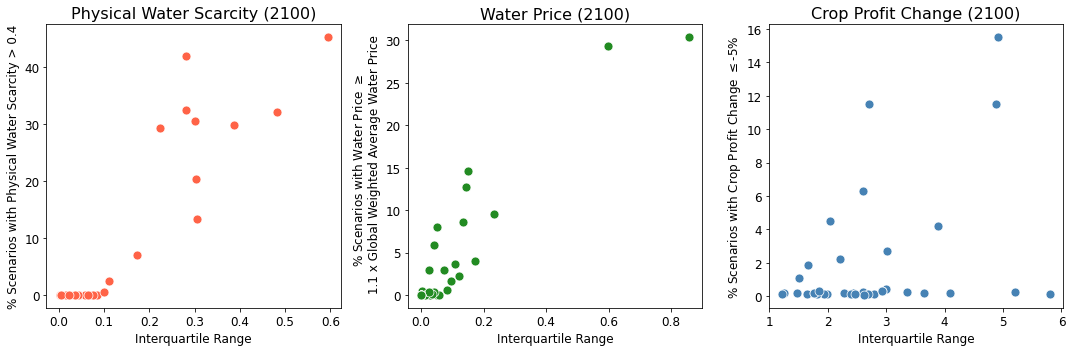

In [11]:
#PLOT
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

sns.scatterplot(ax=ax1,data=stats_yr,x='unc_pws',y='sev_pws',s=80,color='tomato')
ax1.set_title('Physical Water Scarcity ('+str(yr)+')',fontsize=16)
ax1.set_ylabel('% Scenarios with Physical Water Scarcity > 0.4',fontsize=12)
ax1.set_xlabel('Interquartile Range',fontsize=12)

sns.scatterplot(ax=ax2,data=stats_yr,x='unc_wprice',y='sev_wprice',s=80,color='forestgreen')
ax2.set_title('Water Price ('+str(yr)+')',fontsize=16)
ax2.set_ylabel('% Scenarios with Water Price $\geq$  \n 1.1 x Global Weighted Average Water Price',fontsize=12)
ax2.set_xlabel('Interquartile Range',fontsize=12)

sns.scatterplot(ax=ax3,data=stats_yr,x='unc_profit',y='sev_profit',s=80,color='steelblue')
ax3.set_title('Crop Profit Change ('+str(yr)+')',fontsize=16)
ax3.set_ylabel('% Scenarios with Crop Profit Change $\leq$-5%',fontsize=12)
ax3.set_xlabel('Interquartile Range',fontsize=12)

#change tick label size
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

# Figure 4: CART trees for physical water scarcity extremes

See R script at /scripts/main_figures/CART_classification_physicalwaterscarcity.R

# Figure 5: Land Allocation in Rio Grande River Basin

This figure shows change in land allocation from 2015 in the Rio Grande basin for two scenarios that share all parameter assumptions except for TAX (one is FFICT, one is UCT)

In [12]:
#stacked barplot overtime

def plot_landchange(df,plt_title):

    """Plot of land allocation for basin in scenarios - add more to this description
    Inputs:
    df = dataframe with land allocation for given water basin through 2100 for a scenario with FFICT and a 
    scenario with UCT (all other parameter assumptions are the same)
    Outputs:
    plot of land allocation change since 2015 for UCT and FFICT
    """
    sectors = df.crop.unique()[:] #list of land types
    #list of years since 2015
    years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]

    #split up land into different categories
    crops = ['Corn','FiberCrop','FodderGrass','FodderHerb',
            'MiscCrop', 'OilCrop','OtherGrain','Rice','Root_Tuber',
            'SugarCrop','Wheat','PalmFruit']
    bmass =  ['biomass_grass','biomass_tree']
    protected_land =  ['ProtectedGrassland','ProtectedShrubland',
            'ProtectedUnmanagedPasture','ProtectedUnmanagedForest']
    forest = ['Forest','UnmanagedForest']
    nonarable = ['Tundra','RockIceDesert','UrbanLand']
    grassshrub =  ['Grassland','Shrubland']
    pasture = ['Pasture','UnmanagedPasture']
    otherarable = ['OtherArableLand']

    landtype_list = [crops,bmass,protected_land,forest,nonarable,grassshrub,pasture,otherarable]
    landtype_list_name = ['Crops','Biomass','Protected Land','Forest (not protected)','Non-Arable Land',
                         'Grassland/Shrubland','Pasture','Other Arable Land']

    #categorize each land use by type
    df['land_type'] = ''
    for i in range(len(landtype_list[:])): #loop through land types
        df.loc[df['crop'].isin(landtype_list[i]),'land_type'] = landtype_list_name[i]

    df_group = df.groupby(['Units','year','basin','tax','land_type'])['value'].sum() #sum across land types
    df_group = df_group.reset_index()

    #create dataframes for UCT and FFICT (limit to years 2015 and later)
    df_uct = df_group[(df_group.tax=='uct') & (df_group.year>=2015)]
    df_ffict = df_group[(df_group.tax=='ffict') & (df_group.year>=2015)]

    #create column "val_5" that represents the value in 2015
    df_uct['val_2015'] = 0
    df_ffict['val_2015'] = 0

    #get value in 2015
    for i in range(len(landtype_list_name)): #loop through land types
        for j in range(len(years)): #loop through years
            yr = years[j]
            val2015_uct = df_uct[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==2015)]['value'].iloc[0]
            val2015_ffict = df_ffict[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==2015)]['value'].iloc[0]       
            df_uct.loc[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==yr),'val_2015'] = val2015_uct
            df_ffict.loc[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==yr),'val_2015'] = val2015_ffict

    #calculate time period change (difference in value from 2015 to yr)
    df_uct['diff_2015'] = df_uct['value'] - df_uct['val_2015']
    df_ffict['diff_2015'] = df_ffict['value'] - df_ffict['val_2015']

    #pivot table (rearrange table for stacked bar chart)
    #remove protected land and non-arable land (don't change)
    table_uct = pd.pivot_table(df_uct[(df_uct.year>2015) & (~df_uct.land_type.isin(['Protected Land','Non-Arable Land']))], 
                               values='diff_2015', index=['year'],
                        columns=['land_type'])
    table_ffict = pd.pivot_table(df_ffict[(df_ffict.year>2015) & (~df_ffict.land_type.isin(['Protected Land','Non-Arable Land']))], 
                                 values='diff_2015', index=['year'],
                        columns=['land_type'])

    #PLOTTING
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8),sharey=True)

    #dictionary of colors
    c_list = {'Crops':'#ffff99',
              'Biomass':'#b2df8a',
                    'Forest (not protected)':'#33a02c',
                   'Non-Arable Land':'#fb9a99',
                   'Grassland/Shrubland':'#a6cee3',
                   'Pasture':'#fdbf6f',
                 'Other Arable Land':'#1f78b4',
             'Protected Land':'#b3b3b3'}

    #plot uct
    table_uct.plot.bar(ax=ax1,y=table_uct.columns,stacked=True,color=c_list,legend=False)
    ax1.set_xlabel('')
    ax1.set_xticks([0,4,8,12,16])
    ax1.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax1.set_ylabel('$\Delta$Land Allocation from 2015 (thous $km^2$)',fontsize=12)
    ax1.set_title('Universal Carbon Tax',fontsize=12)
    ax1.axhline(c='black',lw=0.5)

    #plot ffict
    table_ffict.plot.bar(ax=ax2,y=table_ffict.columns,stacked=True,color=c_list)
    ax2.legend(title='Land Type',loc='lower left',frameon=True,ncol=2)
    ax2.set_xlabel('')
    ax2.set_xticks([0,4,8,12,16])
    ax2.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax2.set_title('Fossil Fuel and Industrial Carbon Tax',fontsize=12)
    ax2.axhline(c='black',lw=0.5)

    plt.suptitle(plt_title,fontsize=16)

    plt.tight_layout()
    plt.savefig('C:/Users/abirnb01/Documents/Research/NEXO-UA/Paper1/figure5.jpg')
    plt.show()

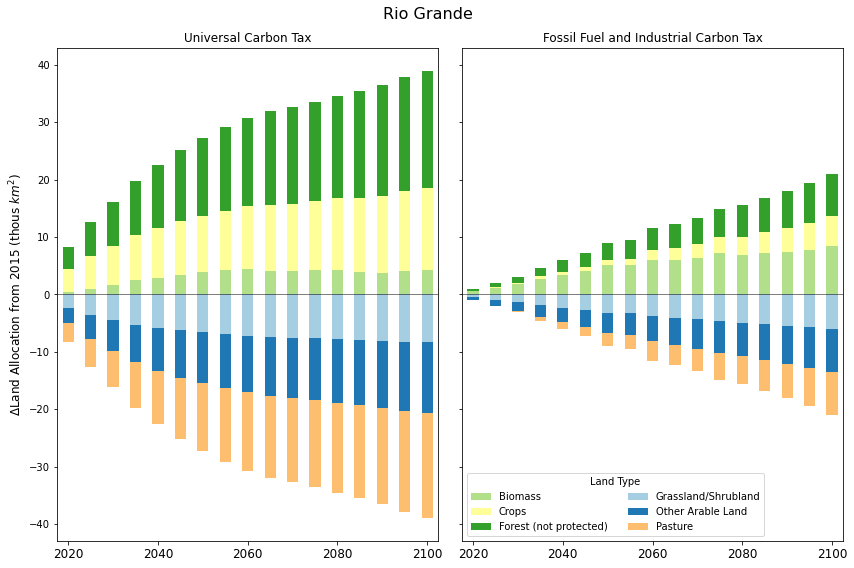

In [13]:
#looking at land allocation for two scenarios with ffict vs uct in the rio grande
plot_landchange(riogrande_tax_lalloc,'Rio Grande')

# Figure 6: CART Trees for water price extremes

See R script at /scripts/main_figures/CART_classification_waterprice.R

# Figure 7: CART tree for crop profit extremes

See R script at /scripts/main_figures/CART_classification_cropprofit.R

# Calculate # Scenarios Extreme for All Metrics

In [14]:
def count_extreme(df):
    """Calculate #scenarios that are extreme for all three scarcity metrics for all basins, years"""
    stor_df = [] #initialize empty dataframe
    basins = df.basin.unique()[:]
    years = df.year.unique()[:]
    for bs in basins:
        for yr in years:
            df_filt = df[(df.basin==bs) & (df.year==yr)] #filter input dataframe to basin and year of interest

            #remove duplicates (when ag = soc and all else equal, OSF parameter doesn't matter)
            df_filt = df_filt.drop_duplicates(['tax','esm','res','gw','soc','ag','pws'])

            #p = np.quantile(df_filt['profit_pchange'],0.05)    #calculate extreme land prfit threshold
            p = -5
            
            #scenario is extreme for all three metrics
            df_filt['all_true'] = ((df_filt['profit_pchange'] <= p) & #crop profit is extreme
                                    (df_filt['pws']>0.4) &  #physical water scarcity is extreme
                                   (df_filt['price_scenario']>=1.1*df_filt['weighted_price_scenario'])) #water price is extreme
            pws_val = sum(df_filt['pws']>0.4)
            price_val = sum(df_filt['price_scenario']>=1.1*df_filt['weighted_price_scenario'])
            profit_val = sum(df_filt['profit_pchange'] <= p)
            all_val = sum(df_filt['all_true'])
            
            #populate row of stor_df
            stor_row = []
            stor_row.append(bs) #append basin name
            stor_row.append(yr) #append year
            stor_row.append(pws_val) #append #scenarios that are extreme for all three metrics
            stor_row.append(price_val) #append #scenarios that are extreme for all three metrics
            stor_row.append(profit_val) #append #scenarios that are extreme for all three metrics
            stor_row.append(all_val) #append #scenarios that are extreme for all three metrics
            
            stor_df.append(stor_row) #append data_stor for basin to list that contains all basin results

    res_data = pd.DataFrame(stor_df) #make stats_stor into dataframe called res_data
    res_data = res_data.rename(columns={0:'basin',1:'year',2:'num_pws',3:'num_wprice',
                                       4:'num_profit',5:'num_all'}) #rename columns of res_data
    return res_data

In [15]:
#metrics_glob = metrics.merge(glob_wprice,on=['year','res','esm','tax','soc','ag','osf','gw'])
metrics_glob = metrics_glob[metrics_glob.year==2100] #limit to just 2100
metrics_count = count_extreme(metrics_glob)
display(metrics_count)

,basin,year,num_pws,num_wprice,num_profit,num_all
0,Amazon,2100,0,0,4,0
1,Baja California,2100,868,60,6,0
2,Caribbean Coast,2100,0,99,3,0
3,Caribbean,2100,0,107,12,0
4,Central Patagonia Highlands,2100,0,0,6,0
5,Colombia-Ecuador-Pacific Coast,2100,0,0,3,0
6,East Brazil-South Atlantic Coast,2100,0,0,418,0
7,Grijalva-Usumacinta,2100,0,0,3,0
8,Isthmus of Tehuantepec,2100,0,0,3,0
9,La Plata,2100,0,0,4,0


# Figure 8: CART trees for scenarios that are extreme for all three metrics

See R script at /scripts/main_figures/CART_classification_allmetrics_extreme.R